In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/credit-card/credit.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import lightgbm as lgb
from sklearn.model_selection import KFold
from imblearn.metrics import  geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [2]:
df = pd.read_csv('/content/credit.csv',  delimiter=',')

df



ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  Class
0          1      20000    2          2  ...         0         0         0      1
1          2     120000    2          2  ...      1000         0      2000      1
2          3      90000    2          2  ...      1000      1000      5000      0
3          4      50000    2          2  ...      1100      1069      1000      0
4          5      50000    1          2  ...      9000       689       679      0
...      ...        ...  ...        ...  ...       ...       ...       ...    ...
29995  29996     220000    1          3  ...      3047      5000      1000      0
29996  29997     150000    1          3  ...       129         0         0      0
29997  29998      30000    1          2  ...      4200      2000      3100      1
29998  29999      80000    1          3  ...      1926     52964      1804      1
29999  30000      50000    1          2  ...      1000      1000      1000      1

[30000 rows x 25 columns]

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Class        0
dtype: int64


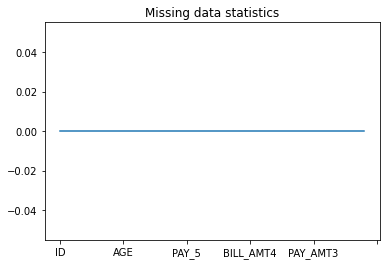

In [3]:
c = df.isnull().sum()
plt.title("Missing data statistics")
c.plot(kind='line')
print(c)

Count of Non-Default clients 23364
Count of Default clients 6636


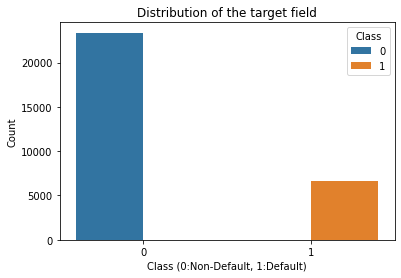

In [4]:
Non_default, Default = df['Class'].value_counts()
print('Count of Non-Default clients', Non_default)
print('Count of Default clients', Default)
sns.countplot(x="Class", hue="Class", data=df)
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Default, 1:Default)')
plt.title('Distribution of the target field')
plt.show()

In [5]:
df.shape

(30000, 25)

In [6]:
df = df[(df['LIMIT_BAL'] >= 0) & (df['BILL_AMT1'] >= 0) & (df['BILL_AMT2'] >= 0) & (df['BILL_AMT3'] >= 0) & (df['BILL_AMT4'] >= 0) &
        (df['BILL_AMT5'] >= 0)& (df['BILL_AMT6'] >= 0) & (df['PAY_AMT1'] >= 0) & (df['PAY_AMT2'] >= 0) & 
        (df['PAY_AMT3'] >= 0) & (df['PAY_AMT4'] >= 0) & (df['PAY_AMT5'] >= 0) & (df['PAY_AMT6'] >= 0)]

In [7]:
df.shape

(28070, 25)

In [8]:
data = df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
           'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
           'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']] = scaler.fit_transform(data)

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  Class
0          1  -1.119864    2          2  ... -0.319376 -0.326208 -0.294673      1
1          2  -0.344569    2          2  ... -0.251699 -0.326208 -0.178969      1
2          3  -0.577157    2          2  ... -0.251699 -0.257342 -0.005413      0
3          4  -0.887275    2          2  ... -0.244931 -0.252590 -0.236821      0
4          5  -0.887275    1          2  ...  0.289718 -0.278759 -0.255391      0
...      ...        ...  ...        ...  ...       ...       ...       ...    ...
29994  29995  -0.654687    1          2  ...  0.154364 -0.326208 -0.063265      1
29995  29996   0.430727    1          3  ... -0.113164  0.018122 -0.236821      0
29996  29997  -0.111980    1          3  ... -0.310645 -0.326208 -0.294673      0
29997  29998  -1.042334    1          2  ... -0.035132 -0.188476 -0.115332      1
29999  30000  -0.887275    1          2  ... -0.251699 -0.257342 -0.236821      1

[28070 rows x 25 columns]

In [10]:
y = df['Class']
x = df.drop(['Class','ID'],axis=1)
print(x)

       LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6
0      -1.119864    2          2  ... -0.319376 -0.326208 -0.294673
1      -0.344569    2          2  ... -0.251699 -0.326208 -0.178969
2      -0.577157    2          2  ... -0.251699 -0.257342 -0.005413
3      -0.887275    2          2  ... -0.244931 -0.252590 -0.236821
4      -0.887275    1          2  ...  0.289718 -0.278759 -0.255391
...          ...  ...        ...  ...       ...       ...       ...
29994  -0.654687    1          2  ...  0.154364 -0.326208 -0.063265
29995   0.430727    1          3  ... -0.113164  0.018122 -0.236821
29996  -0.111980    1          3  ... -0.310645 -0.326208 -0.294673
29997  -1.042334    1          2  ... -0.035132 -0.188476 -0.115332
29999  -0.887275    1          2  ... -0.251699 -0.257342 -0.236821

[28070 rows x 23 columns]


In [12]:
def initilization_of_population_featurebased(size,n_feat):
    population = []
    #chromosome = []
    for j in range(size): 
        chromosome = []    #chromosome type is list
        for i in range(n_feat):
            if i == 0:
                gene = round(random.uniform(-0.34, -1.11),4)
            elif i == 1:
                gene = random.randint(1, 2)
            elif i == 2:
                gene = random.randint(1,2)
            elif i == 3:
                gene = random.randint(1,2)
            elif i == 4:
                gene = random.randint(22,43)
            elif i == 5:
                gene = random.randint(-1,2)
            elif i == 6:
                gene = random.randint(-1,2)
            elif i == 7:
                gene = random.randint(-1,2)
            elif i == 8:
                gene = random.randint(-1,2)
            elif i == 9:
                gene = random.randint(-1,2)
            elif i == 10:
                gene = random.randint(-1,2)
            elif i == 11:
                gene = round(random.uniform(-0.13, 0.48),4)
            elif i == 12:
                gene = round(random.uniform(-0.68, 0.4),4)
            elif i == 13:
                gene = round(random.uniform(-0.07, 0.4),2)
            elif i == 14:
                gene = round(random.uniform(-0.1,0.48),4)
            elif i == 15:
                gene = round(random.uniform(-0.16,0.65),4)
            elif i == 16:
                gene = round(random.uniform(-0.3,0.66),4)
            elif i == 17:
                gene = round(random.uniform(-0.2,0.08),4)
            elif i == 18:
                gene = round(random.uniform(-0.2,0.1),4)
            elif i == 19:
                gene = round(random.uniform(-0.2,0.98),4)
            elif i == 20:
                gene = round(random.uniform(-0.03,0.15),4)
            elif i == 21:
                gene = round(random.uniform(-0.1,-0.3),4)
            else:
                gene =  round(random.uniform(-0.06,-0.29),4)
            chromosome.append(gene)
        population.append(chromosome)
    return(population)

In [13]:
def fitness_score(population,model,X_train,X_test, y_train, y_test):
    scores = []
    for chromosome in population:
        a_series = pd.Series(chromosome, index = X_train.columns)
        b_series = pd.Series([1])
        X_train_with_chromosome = X_train.append(a_series, ignore_index=True)
        y_train_with_chromosome = y_train.append(b_series, ignore_index=True)
        model.fit(X_train_with_chromosome,np.ravel(y_train_with_chromosome))
        predictions = model.predict(X_test)
        scores.append(f1_score(np.ravel(y_test), predictions))
    scores, population = np.array(scores), np.array(population) # list of arrays scores = [[array1],[array2]]
    inds = np.argsort(scores) #[2, 3, 1, 0] indicates that the smallest element is at index 2, the next smallest at index 3, then index 1, then index 0.
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) #list of list (converting each array such as array, array2  0 to list in sorted order)

In [14]:
def selection(pop_after_fit,n_parents):
    population_nextgen = [] #New array 
    for i in range(n_parents): 
        population_nextgen.append(pop_after_fit[i])  # append the best chromosomes as parents from results after fit function
    return population_nextgen 

In [15]:
def clone(pop_after_sel, clone_rate):
    population_next_gen_cloned = []
    population_next_gen=pop_after_sel
    for x in range(clone_rate):
            for i in range(len(population_next_gen)):
                clones = population_next_gen[i]
                population_next_gen_cloned.append(clones)
    return population_next_gen_cloned
    

In [16]:
def mutation_clone(pop_after_clone,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_clone)):  #consider each chromoseome from the cross over set
        chromosome = pop_after_clone[i]  #take in sequence one after other chromosomes
        for j in range(len(chromosome)):  #with the one chromosome array
            if j == 0:  #Up to us can be anything here we see if randomly generated value < mutate
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)))
            elif j== 1:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 2:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 3:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 4:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 5:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 6:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 7:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 8:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 9:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 10:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))   
            elif j== 11:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 12:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 13:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 14:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 15:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 16:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 17:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 18:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 19:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 20:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 21:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            else:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
        population_nextgen.append(chromosome)  #append all the changed ones to next_gen
    
    return population_nextgen

In [17]:
def generations(size,n_feat,n_parents,mutation_rate, clone_rate,model,X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    stop_condition = True
    i = 0
    fscore_counter = 0
    bestscore_counter = 0
    population_nextgen=initilization_of_population_featurebased(size,n_feat)
    print('Initial random population based on minority class features')
    print(population_nextgen)
    while stop_condition:
        print(i)
        print('--------------------------------------------------------------------------')
        scores, pop_after_fit = fitness_score(population_nextgen, model,X_train,X_test, y_train, y_test)
        print('Scores of each chromosomes in sorted order')
        print(scores)
        print('Chromosome set sorted and corresponding to scores')
        print(pop_after_fit)
        pop_after_sel = selection(pop_after_fit,n_parents)
        print('Selects the best parents to generate better chromosomes for next generation')
        print(pop_after_sel)
        print("Clone after selection based on clone_rate")
        pop_after_clone = clone(pop_after_sel, clone_rate)
        print(pop_after_clone)
        print('Mutate the cloned population')
        population_nextgen = mutation_clone(pop_after_clone,mutation_rate)
        print(population_nextgen)
        if i > 0:
             if round(best_score[-1],5) >= round(scores[0],5):
                    print("Checking if the values are degrading or equal")
                    fscore_counter = fscore_counter + 1
                    print(fscore_counter)
                    if fscore_counter == 10 :
                        print("&&&&&&&&&--------Fscore_counter is checked and near to 10--------&&&&&&&&&&&&&")
                        stop_condition = False
                        
             elif stop_condition == True:
                if round(best_score[-1],5) < round(scores[0],5):
                    print("&&&&&&&&&&&&&&-----Fscore_counter is recompiled to O-------&&&&&&&&&&&&&&&&&")
                    fscore_counter = 0
             if stop_condition == True:
                if len(best_score) > 150:
                    print("-----Length of best score is exceeded so stopping the AIS now--------")
                    stop_condition = False
             #else:
               # stop_condition = True
                    
        i = i + 1
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('best score and chromosome')
        print(best_chromo)
        print(best_score)
        
    return best_chromo, best_score

In [18]:
def update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train):
    X_train = Initial_X_train
    y_train = Initial_y_train
    for best_chromo in chromo:
        X_train_bestchromo = []
        a_series = pd.Series(best_chromo, index = X_train.columns)
        b_series = pd.Series([1])
        X_train_bestchromo = X_train.append(a_series, ignore_index=True)
        X_train = X_train_bestchromo
        y_train_bestchromo = y_train.append(b_series)
        y_train = y_train_bestchromo
    return X_train, y_train

In [19]:
def modelling_using_AIS_SampledTrainset(AIS_X_train, AIS_y_train, AIS_X_test, AIS_y_test,classifier):
    model = classifier
    model.fit(AIS_X_train,np.ravel(AIS_y_train))
    predictions = model.predict(AIS_X_test)
    acc, recal, precis, aucroc, gmean, _val = evaluation(predictions, AIS_y_test)
    
    return acc, recal, precis, aucroc, gmean, _val
    
    

In [20]:
def evaluation(pred_values, y_test):
    
    acc = accuracy_score(np.ravel(y_test), pred_values)
    recal = recall_score(np.ravel(y_test), pred_values)
    precis = precision_score(np.ravel(y_test), pred_values)
    #val = f1_score(y_test, pred_values)
    aucroc = roc_auc_score(np.ravel(y_test), pred_values)
    _val = f1_score(np.ravel(y_test), pred_values)
    gmean = geometric_mean_score(np.ravel(y_test), pred_values)
    
    return acc, recal, precis, aucroc, gmean, _val

In [21]:
def AIS_sampling_and_modelling(x,y,model,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(X_train_AISsampled, y_train_AISsampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [22]:
def AIS_with_resampling(x,y,model,sampler,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    sampleclassifier = sampler
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('----------------*****Applying sampling {0} technique on updated AIS train datasets******----------'.format(sampleclassifier))
        AIS_X_train_sampled, AIS_y_train_sampled = sampleclassifier.fit_resample(X_train_AISsampled, np.ravel(y_train_AISsampled))
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(AIS_X_train_sampled, AIS_y_train_sampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [23]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostModel = AdaBoostClassifier()

In [ ]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.4435, 1, 2, 1, 37, 2, 2, 2, 0, -1, 2, -0.1127, 0.2226, 0.13, 0.3421, -0.1583, 0.1276, 0.002, -0.1314, 0.9154, 0.1323, -0.1061, -0.0659], [-0.7569, 2, 1, 2, 22, 0, 2, 2, 0, 1, 0, 0.2829, 0.1418, 0.38, 0.4374, 0.1771, 0.5796, 0.0582, -0.17, 0.5426, 0.1003, -0.1593, -0.2309], [-1.0296, 2, 1, 2, 31, 2, 2, -1, 2, 0, 2, 0.1227, -0.4932, 0.19, 0.3078, 0.3863, 0.0597, -0.0771, -0.0475, 0.7186, 0.0638, -0.1787, -0.1726], [-0.3628, 1, 2, 2, 42, 0, 0, 0, -1, 0, 0, 0.1167, -0.3087, 0.33, 0.1049, 0.5769, 0.3328, -0.0295, 0.0188, 0.2528, 0.1243, -0.2909, -0.2758]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.4180548092423428, 0.4

In [ ]:
lgbmodel = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)

random.seed(1)

AIS_sampling_and_modelling(x,y,model = lgbmodel,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.4435, 1, 2, 1, 37, 2, 2, 2, 0, -1, 2, -0.1127, 0.2226, 0.13, 0.3421, -0.1583, 0.1276, 0.002, -0.1314, 0.9154, 0.1323, -0.1061, -0.0659], [-0.7569, 2, 1, 2, 22, 0, 2, 2, 0, 1, 0, 0.2829, 0.1418, 0.38, 0.4374, 0.1771, 0.5796, 0.0582, -0.17, 0.5426, 0.1003, -0.1593, -0.2309], [-1.0296, 2, 1, 2, 31, 2, 2, -1, 2, 0, 2, 0.1227, -0.4932, 0.19, 0.3078, 0.3863, 0.0597, -0.0771, -0.0475, 0.7186, 0.0638, -0.1787, -0.1726], [-0.3628, 1, 2, 2, 42, 0, 0, 0, -1, 0, 0, 0.1167, -0.3087, 0.33, 0.1049, 0.5769, 0.3328, -0.0295, 0.0188, 0.2528, 0.1243, -0.2909, -0.2758]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted 

In [25]:
sampler_smt = SMOTE(random_state=0)

In [ ]:
AIS_with_resampling(x,y,model = AdaBoostModel,sampler = sampler_smt,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.6344, 2, 2, 1, 32, 2, 0, 2, 0, -1, 2, 0.2364, -0.2391, -0.01, 0.0714, 0.0411, 0.4196, -0.1989, -0.143, 0.3178, -0.0262, -0.2255, -0.1993], [-0.9832, 1, 1, 2, 26, 0, 1, 1, 1, 2, 0, 0.2027, -0.1499, 0.33, 0.3461, 0.3021, 0.0679, -0.1205, -0.1676, 0.7529, -0.0087, -0.2495, -0.1854], [-1.083, 1, 1, 2, 40, 1, 2, 1, 1, -1, -1, 0.1398, -0.1945, 0.07, 0.1317, 0.4743, 0.3561, -0.0622, -0.0057, 0.2455, 0.0067, -0.1008, -0.1239], [-0.8006, 1, 2, 2, 31, 0, 2, 0, 1, -1, 2, 0.2234, 0.3679, 0.09, 0.2605, 0.6293, 0.3715, 0.0709, -0.1797, 0.9654, 0.0146, -0.2934, -0.1269]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.420375335120643

In [ ]:
AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_smt,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.9528, 2, 2, 2, 34, 2, -1, 2, 1, 0, 2, -0.0396, 0.3946, 0.31, 0.1133, -0.057, 0.4547, 0.0659, -0.0761, 0.9081, 0.0217, -0.1842, -0.1229], [-0.5986, 2, 1, 2, 34, 2, -1, -1, 0, 0, 0, 0.0098, -0.6518, 0.05, 0.1783, 0.6113, 0.0832, 0.0026, 0.0503, -0.0948, 0.0801, -0.2992, -0.1864], [-0.7516, 2, 1, 1, 39, 2, -1, 1, 1, 0, 2, 0.3611, 0.0805, -0.05, 0.0242, 0.3619, 0.5317, -0.1653, -0.0658, 0.6047, 0.0596, -0.1786, -0.1994], [-0.709, 1, 2, 1, 27, 1, 2, 1, 2, 0, 1, 0.3952, -0.5689, 0.29, 0.323, 0.121, 0.5498, -0.0015, -0.1831, 0.538, 0.024, -0.2808, -0.0832]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.46

In [24]:
lgbmodel = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)

In [26]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_smt,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.666, 1, 1, 2, 36, 2, 0, -1, 2, 0, 1, 0.2064, 0.2975, 0.11, 0.0384, 0.6177, 0.382, 0.0692, -0.0513, 0.7499, 0.0898, -0.1124, -0.2857], [-0.4927, 1, 1, 1, 28, -1, 0, 2, -1, 2, 0, 0.0034, 0.0783, 0.25, 0.1523, 0.2964, -0.1996, -0.0753, 0.0146, 0.505, 0.1487, -0.272

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.8203, 1, 1, 1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.8771, 2, 1, 1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Streaming output truncated to the last 5000 lines.
       -1.0000e+00,  1.1220e-01,  1.5540e-01,  2.0000e-02,  8.4000e-02,
        5.6420e-01,  3.9610e-01,  7.8100e-02, -1.2330e-01,  8.7200e-01,
       -1.3800e-02, -1.4740e-01, -1.5730e-01]), array([-5.538e-01,  1.000e+00,  1.000e+00,  1.000e+00,  3.000e+01,
        1.000e+00, -1.000e+00, -1.000e+00,  1.000e+00,  2.000e+00,
        2.000e+00,  3.213e-01, -2.280e-02,  2.400e-01,  3.252e-01,
        2.675e-01,  5.698e-01, -1.993e-01,  9.160e-02,  8.067e-01,
       -2.220e-02, -2.418e-01, -9.220e-02]), array([-4.807e-01,  1.000e+00,  1.000e+00,  1.000e+00,  2.900e+01,
       -1.000e+00,  1.000e+00, -1.000e+00,  1.000e+00,  2.000e+00,
        1.000e+00,  3.566e-01, -4.490e-02, -2.000e-02, -7.880e-02,
        5.794e-01,  1.180e-01, -1.781e-01, -1.094e-01,  7.020e-01,
        7.640e-02, -2.494e-01, -2.173e-01])]
Selects the best parents to generate better chromosomes for next generation
[array([-9.518e-01,  2.000e+00,  1.000e+00,  2.000e+00,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.563, 1, 2, 2, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
Metrics for each fold of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) using AIS algorithm
Accuracy : [0.8085144282151764, 0.8127894549340934, 0.8147488421802637, 0.825258282864268, 0.8238332739579622]
Avg accuracy : 0.8170288564303527
Recall : [0.377373417721519, 0.4223798266351458, 0.4218009478672986, 0.42891566265060244, 0.4411302982